In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW

# --- Riga Extractor Network ---

class RigaExtractor(nn.Module):
    """Extractor network that projects weights to watermark space."""
    def __init__(self, weight_size, watermark_len):
        super().__init__()
        self.fc1 = nn.Linear(weight_size, 100, bias=False)
        self.fc2 = nn.Linear(100, watermark_len, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig(out)
        out = self.fc2(out)
        out = self.sig(out)
        return out


# --- Riga Detector Network ---

class RigaDetector(nn.Module):
    """Detector network that distinguishes watermarked from non-watermarked weights."""
    def __init__(self, weight_size):
        super().__init__()
        self.fc1 = nn.Linear(weight_size, 100, bias=False)
        self.fc2 = nn.Linear(100, 1, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig(out)
        out = self.fc2(out)
        out = self.sig(out)
        return out


# --- Classe Principale Riga DDPM ---

class RigaDDPM:
    def __init__(self, model_id, device="cuda"):
        self.device = device
        self.model_id = model_id

        # Chargement du modele
        self.pipeline = DDPMPipeline.from_pretrained(model_id)
        self.unet = self.pipeline.unet.to(device)
        self.scheduler = self.pipeline.scheduler

        # Configuration par defaut
        self.config = {
            "layer_name": "mid_block.resnets.0.conv1.weight",  # Couche cible
            "watermark_len": 64,
            "lr": 1e-4,
            "lr_det": 1e-3,        # Learning rate for detector
            "lambda_1": 1.0,       # Watermark loss weight
            "lambda_2": 1.0,       # Adversarial loss weight
            "epochs": 30,
            "clip_value": 0.01,    # Weight clipping for detector (WGAN-style)
        }

        self.saved_keys = {}

    def _get_target_weights(self, model):
        """Recupere le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Parametre {self.config['layer_name']} introuvable.")

    def embed(self, dataloader):
        """
        Incorpore la marque Riga pendant le finetuning.
        Utilise un entrainement adversarial avec un detecteur.
        """
        print(f"--- Demarrage Embedding Riga ({self.config['layer_name']}) ---")

        watermarked_unet = self.unet
        watermarked_unet.train()

        # 1. Get initial weights
        target_weights = self._get_target_weights(watermarked_unet)
        with torch.no_grad():
            init_w = torch.flatten(target_weights.mean(dim=0)).clone()
            weight_size = len(init_w)

        print(f"Dimension vecteur poids : {weight_size} | Watermark : {self.config['watermark_len']} bits")

        # 2. Generate watermarks
        watermark_target = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)
        watermark_random = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)

        # 3. Initialize networks
        extractor = RigaExtractor(weight_size, self.config["watermark_len"]).to(self.device)
        detector = RigaDetector(weight_size).to(self.device)

        # 4. Optimizers
        optimizer = torch.optim.AdamW([
            {'params': watermarked_unet.parameters(), 'lr': self.config["lr"]},
            {'params': extractor.parameters(), 'lr': self.config["lr"], 'betas': (0.5, 0.999)}
        ])
        optimizer_det = torch.optim.Adam(
            detector.parameters(),
            lr=self.config["lr_det"],
            betas=(0.5, 0.999)
        )

        mse_loss = nn.MSELoss()
        bce_loss = nn.BCELoss()

        # 5. Training loop
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader)
            for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)
                bs = clean_images.shape[0]

                # Get current weights
                current_weights = self._get_target_weights(watermarked_unet)
                w = torch.flatten(current_weights.mean(dim=0))

                # Sort weights for detector (as in original Riga)
                w_sorted = torch.sort(w.detach())[0]
                init_w_sorted = torch.sort(init_w.detach())[0]

                # === A. Train Detector ===
                optimizer_det.zero_grad()

                # Detector should output 1 for non-watermarked, 0 for watermarked
                out_det_wat = detector(w_sorted)
                out_det_non = detector(init_w_sorted)

                loss_det_non = bce_loss(out_det_non, torch.ones(1).to(self.device))
                loss_det_wat = bce_loss(out_det_wat, torch.zeros(1).to(self.device))
                loss_det = loss_det_non + loss_det_wat

                loss_det.backward(retain_graph=True)
                optimizer_det.step()

                # Clip detector weights (WGAN-style)
                with torch.no_grad():
                    for param in detector.parameters():
                        param.clamp_(-self.config["clip_value"], self.config["clip_value"])

                # === B. Train UNet + Extractor ===
                # Diffusion loss
                noise = torch.randn_like(clean_images).to(self.device)
                timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (bs,), device=self.device).long()
                noisy_images = self.scheduler.add_noise(clean_images, noise, timesteps)

                optimizer.zero_grad()

                noise_pred = watermarked_unet(noisy_images, timesteps).sample
                l_main = mse_loss(noise_pred, noise)

                # Watermark extraction loss
                w_current = torch.flatten(self._get_target_weights(watermarked_unet).mean(dim=0))
                out_watermark = extractor(w_current)
                init_out_watermark = extractor(init_w.detach())

                loss_ext_wat = bce_loss(out_watermark, watermark_target)
                loss_ext_init = bce_loss(init_out_watermark, watermark_random)

                # Adversarial loss (fool detector - make it think watermarked is non-watermarked)
                w_sorted_current = torch.sort(w_current.detach())[0]
                out_det_current = detector(w_sorted_current)
                loss_adv = bce_loss(out_det_current, torch.ones(1).to(self.device))

                # Total loss
                l_total = (l_main +
                          self.config["lambda_1"] * (loss_ext_wat + loss_ext_init) -
                          self.config["lambda_2"] * loss_adv)

                l_total.backward()
                optimizer.step()

                # Metrics
                ber = self._compute_ber(out_watermark, watermark_target)
                pbar.set_description(
                    f"Epoch {epoch+1} | L_Main: {l_main:.3f} | L_Ext: {loss_ext_wat:.3f} | "
                    f"L_Det: {loss_det:.3f} | BER: {ber:.2f}"
                )

                # if ber == 0.0 and loss_ext_wat.item() < 0.01:
                #     print("Convergence atteinte !")
                #     break
            # if ber == 0.0:
            #     break

        # Save keys
        self.saved_keys = {
            "watermark_target": watermark_target,
            "watermarked_unet": watermarked_unet,
            "extractor": extractor,
            "detector": detector,
            "init_w": init_w,
        }
        return watermarked_unet

    def extract(self, suspect_unet=None):
        """
        Extrait la marque d'un modele suspect via le reseau extracteur.
        """
        if suspect_unet is None:
            print('suspected is none')
            suspect_unet = self.saved_keys["watermarked_unet"]

        extractor = self.saved_keys["extractor"]
        watermark_target = self.saved_keys["watermark_target"]

        extractor.eval()

        # Get weights
        try:
            target_weights = self._get_target_weights(suspect_unet)
        except ValueError:
            print("Couche cible introuvable dans le modele suspect.")
            return 1.0, None

        # Extract watermark
        with torch.no_grad():
            w = torch.flatten(target_weights.mean(dim=0))
            pred_wm = extractor(w)
            ber = self._compute_ber(pred_wm, watermark_target)

        print(f"BER Extrait : {ber:.2f}")
        return ber, pred_wm

    def detect(self, suspect_unet=None):
        """
        Detecte si un modele est watermarke via le reseau detecteur.
        Returns: detection score (0 = watermarked, 1 = non-watermarked)
        """
        if suspect_unet is None:
            print("suspected is none")
            suspect_unet = self.saved_keys["watermarked_unet"]

        detector = self.saved_keys["detector"]
        detector.eval()

        try:
            target_weights = self._get_target_weights(suspect_unet)
            print("ok")
        except ValueError:
            print("error")
            return 0.5

        with torch.no_grad():
            w = torch.flatten(target_weights.mean(dim=0))
            w_sorted = torch.sort(w)[0]
            detection_score = detector(w_sorted).item()

        print(f"Detection score: {detection_score:.4f} (0=watermarked, 1=non-watermarked)")
        return detection_score

    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()


/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- EXEMPLE D'EXECUTION ---

# 1. Setup Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 2. Embedding Riga
riga_defense = RigaDDPM("google/ddpm-cifar10-32")
watermarked_model = riga_defense.embed(dataloader)

In [7]:
# 3. Extraction (Test immediat)
ber, _ = riga_defense.extract(watermarked_model)
print(f"\nResultat final - BER: {ber:.2f}")

# 4. Detection
print("\n--- Detection Test ---")
print("Watermarked model:")
riga_defense.detect(watermarked_model)

# Test with fresh model
print("\nFresh (non-watermarked) model:")
fresh_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
fresh_unet = fresh_pipeline.unet.to(riga_defense.device)
riga_defense.detect(fresh_unet)

0.4922058880329132

In [4]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack_riga(riga_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transferer la fonctionnalite du modele Riga vers un modele vierge.
    Verifie si la marque et la detection survivent.
    """
    device = riga_obj.device

    # 1. Teacher (Gele)
    teacher_unet = riga_obj.saved_keys["watermarked_unet"]
    teacher_unet.eval()
    for p in teacher_unet.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Meme architecture)
    print("\n--- Initialisation du Student ---")
    student_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
    student_unet = student_pipeline.unet.to(device)
    student_unet.train()

    teacher_ber, _ = riga_obj.extract(teacher_unet)
    student_ber, _ = riga_obj.extract(student_unet)
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")

    print("\n[Check] Detection scores:")
    print("Teacher:", end=" ")
    riga_obj.detect(teacher_unet)
    print("Student (before):", end=" ")
    riga_obj.detect(student_unet)

    optimizer = AdamW(student_unet.parameters(), lr=lr)
    noise_scheduler = riga_obj.scheduler
    history = {"loss": [], "ber": [], "detection": []}

    print(f"\n--- Distillation Riga ({epochs} epochs) ---")

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)
            bs = clean_images.shape[0]

            noise = torch.randn_like(clean_images).to(device)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with torch.no_grad():
                target_pred = teacher_unet(noisy_images, timesteps).sample

            student_pred = student_unet(noisy_images, timesteps).sample

            loss = F.mse_loss(student_pred, target_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        # Check metrics
        current_ber, pred_wm = riga_obj.extract(student_unet)
        detection_score = riga_obj.detect(student_unet)

        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))
        history["detection"].append(detection_score)

        err_wat = nn.BCELoss()(pred_wm, riga_obj.saved_keys["watermark_target"]).item() if pred_wm is not None else float('nan')
        print(f"Fin Epoch {epoch+1} | Loss: {history['loss'][-1]:.4f} | BER: {current_ber:.2f} | Detection: {detection_score:.4f}")

    return student_unet, history



In [5]:
# 5. Attaque par Distillation
student_res, stats = run_distillation_attack_riga(riga_defense, dataloader, epochs=100)

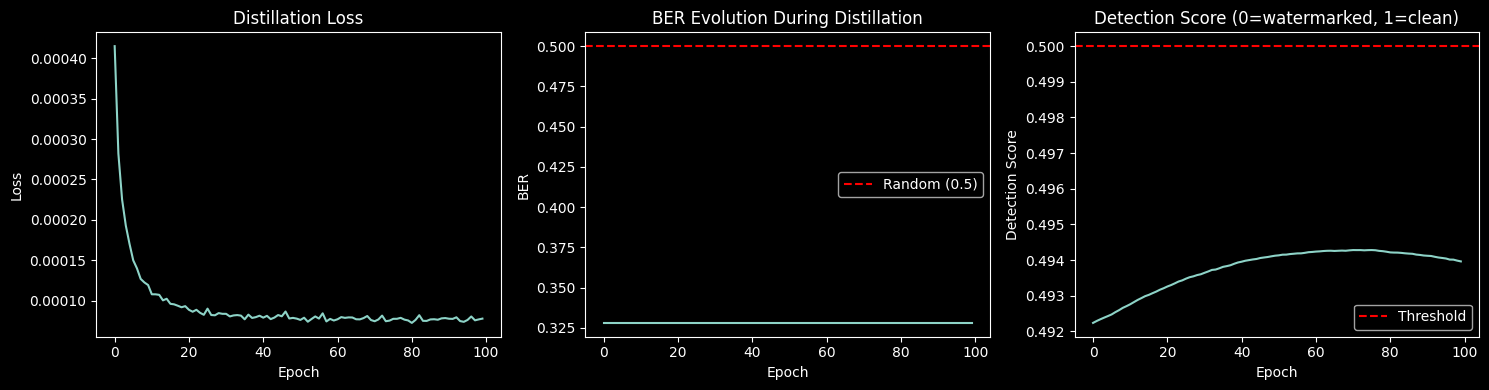

In [6]:
# 6. Visualisation des resultats
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.plot(stats["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Distillation Loss")

ax2.plot(stats["ber"])
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random (0.5)')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("BER")
ax2.set_title("BER Evolution During Distillation")
ax2.legend()

ax3.plot(stats["detection"])
ax3.axhline(y=0.5, color='r', linestyle='--', label='Threshold')
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Detection Score")
ax3.set_title("Detection Score (0=watermarked, 1=clean)")
ax3.legend()

plt.tight_layout()
plt.show()